<a href="https://colab.research.google.com/github/gulabpatel/Anomaly_Detection_Python/blob/main/Anomaly_Detection_using_FBProphet_nyc_taxi_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Link to video explaining the code - https://www.youtube.com/watch?v=0wfOOl5XtcU

In [1]:
!pip install fbprophet

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import pandas as pd
import plotly.express as px

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False


In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv')

In [4]:
df

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820
...,...,...
10315,2015-01-31 21:30:00,24670
10316,2015-01-31 22:00:00,25721
10317,2015-01-31 22:30:00,27309
10318,2015-01-31 23:00:00,26591


In [5]:
df['timestamp']=pd.to_datetime(df['timestamp'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  10320 non-null  datetime64[ns]
 1   value      10320 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 161.4 KB


In [7]:
df.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [8]:
df=df.set_index('timestamp').resample("H").mean()

In [9]:
df

,value
timestamp,
2014-07-01 00:00:00,9485.5
2014-07-01 01:00:00,5433.0
2014-07-01 02:00:00,3346.5
2014-07-01 03:00:00,2216.5
2014-07-01 04:00:00,2189.5
...,...
2015-01-31 19:00:00,28288.5
2015-01-31 20:00:00,24138.0
2015-01-31 21:00:00,24194.5


In [10]:
fig = px.line(df.reset_index(), x='timestamp', y='value', title='NYC Taxi Demand')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="3y", step="year", stepmode="backward"),
            dict(count=3, label="5y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

In [11]:
from fbprophet import Prophet

In [12]:
taxi_df=df.reset_index()[['timestamp','value']].rename({'timestamp':'ds','value':'y'}, axis='columns')

In [13]:
taxi_df

,ds,y
0,2014-07-01 00:00:00,9485.5
1,2014-07-01 01:00:00,5433.0
2,2014-07-01 02:00:00,3346.5
3,2014-07-01 03:00:00,2216.5
4,2014-07-01 04:00:00,2189.5
...,...,...
5155,2015-01-31 19:00:00,28288.5
5156,2015-01-31 20:00:00,24138.0
5157,2015-01-31 21:00:00,24194.5
5158,2015-01-31 22:00:00,26515.0


In [14]:
train=taxi_df[(taxi_df['ds'] >= '2014-07-01') & (taxi_df['ds'] <= '2015-01-27')]
test=taxi_df[(taxi_df['ds'] > '2015-01-27')]

In [15]:
train.shape

(5041, 2)

In [16]:
test.shape

(119, 2)

In [17]:
test

,ds,y
5041,2015-01-27 01:00:00,39.5
5042,2015-01-27 02:00:00,29.0
5043,2015-01-27 03:00:00,9.5
5044,2015-01-27 04:00:00,14.5
5045,2015-01-27 05:00:00,29.0
...,...,...
5155,2015-01-31 19:00:00,28288.5
5156,2015-01-31 20:00:00,24138.0
5157,2015-01-31 21:00:00,24194.5
5158,2015-01-31 22:00:00,26515.0


In [18]:
m = Prophet(changepoint_range=0.95)

In [19]:
m.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [20]:
future = m.make_future_dataframe(periods=119,freq='H')
future.tail(167)

,ds
4993,2015-01-25 01:00:00
4994,2015-01-25 02:00:00
4995,2015-01-25 03:00:00
4996,2015-01-25 04:00:00
4997,2015-01-25 05:00:00
...,...
5155,2015-01-31 19:00:00
5156,2015-01-31 20:00:00
5157,2015-01-31 21:00:00
5158,2015-01-31 22:00:00


In [21]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
5155,2015-01-31 19:00:00,23778.529213,19010.302048,28382.627864
5156,2015-01-31 20:00:00,24342.584334,19937.239788,29076.965034
5157,2015-01-31 21:00:00,23219.297735,18041.987367,27281.121694
5158,2015-01-31 22:00:00,21027.355314,16108.639731,25606.751589
5159,2015-01-31 23:00:00,18500.216845,13627.837599,23241.714871


In [22]:
results=pd.concat([taxi_df.set_index('ds')['y'],forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']]],axis=1)

In [23]:
results

,y,yhat,yhat_lower,yhat_upper
ds,,,,
2014-07-01 00:00:00,9485.5,13240.732792,8655.563019,18042.539748
2014-07-01 01:00:00,5433.0,10232.486172,5579.046087,15109.743446
2014-07-01 02:00:00,3346.5,6669.099458,1660.479963,11399.139266
2014-07-01 03:00:00,2216.5,3448.054270,-1352.595872,8687.639489
2014-07-01 04:00:00,2189.5,2017.409931,-2527.697601,6933.301204
...,...,...,...,...
2015-01-31 19:00:00,28288.5,23778.529213,19010.302048,28382.627864
2015-01-31 20:00:00,24138.0,24342.584334,19937.239788,29076.965034
2015-01-31 21:00:00,24194.5,23219.297735,18041.987367,27281.121694


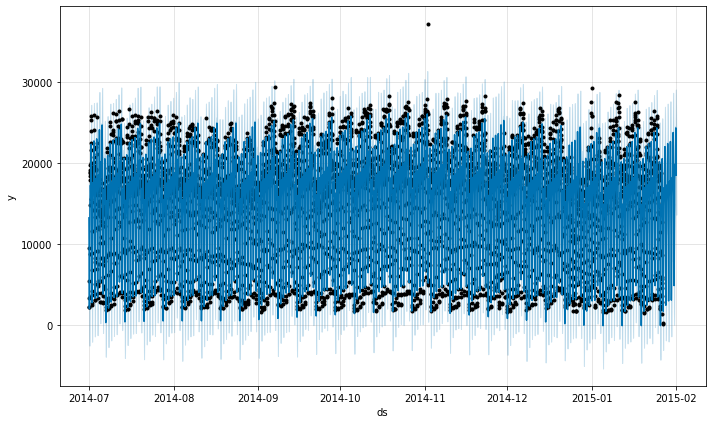

In [24]:
fig1 = m.plot(forecast)

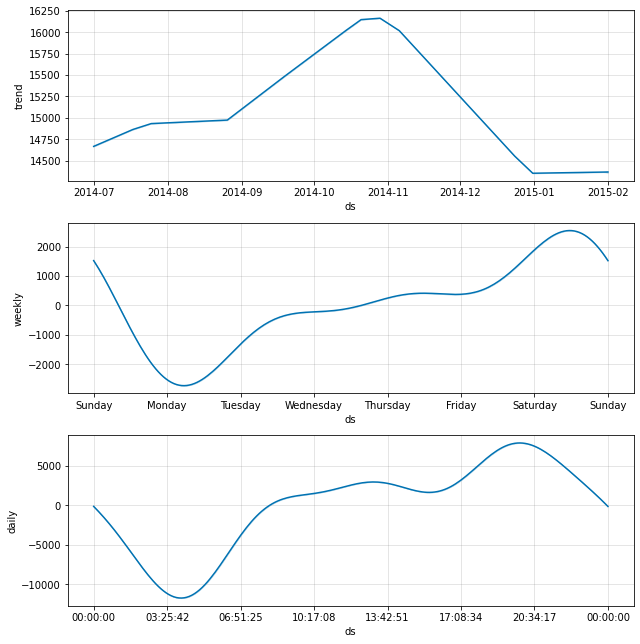

In [25]:
comp=m.plot_components(forecast)

In [26]:
results

,y,yhat,yhat_lower,yhat_upper
ds,,,,
2014-07-01 00:00:00,9485.5,13240.732792,8655.563019,18042.539748
2014-07-01 01:00:00,5433.0,10232.486172,5579.046087,15109.743446
2014-07-01 02:00:00,3346.5,6669.099458,1660.479963,11399.139266
2014-07-01 03:00:00,2216.5,3448.054270,-1352.595872,8687.639489
2014-07-01 04:00:00,2189.5,2017.409931,-2527.697601,6933.301204
...,...,...,...,...
2015-01-31 19:00:00,28288.5,23778.529213,19010.302048,28382.627864
2015-01-31 20:00:00,24138.0,24342.584334,19937.239788,29076.965034
2015-01-31 21:00:00,24194.5,23219.297735,18041.987367,27281.121694


In [27]:
results['error'] = results['y'] - results['yhat']

In [28]:
results["uncertainty"] = results['yhat_upper'] - results['yhat_lower']

In [29]:
results

,y,yhat,yhat_lower,yhat_upper,error,uncertainty
ds,,,,,,
2014-07-01 00:00:00,9485.5,13240.732792,8655.563019,18042.539748,-3755.232792,9386.976729
2014-07-01 01:00:00,5433.0,10232.486172,5579.046087,15109.743446,-4799.486172,9530.697359
2014-07-01 02:00:00,3346.5,6669.099458,1660.479963,11399.139266,-3322.599458,9738.659304
2014-07-01 03:00:00,2216.5,3448.054270,-1352.595872,8687.639489,-1231.554270,10040.235360
2014-07-01 04:00:00,2189.5,2017.409931,-2527.697601,6933.301204,172.090069,9460.998805
...,...,...,...,...,...,...
2015-01-31 19:00:00,28288.5,23778.529213,19010.302048,28382.627864,4509.970787,9372.325816
2015-01-31 20:00:00,24138.0,24342.584334,19937.239788,29076.965034,-204.584334,9139.725246
2015-01-31 21:00:00,24194.5,23219.297735,18041.987367,27281.121694,975.202265,9239.134327


In [30]:
results[results['error'].abs() >  1.5*results['uncertainty']]

,y,yhat,yhat_lower,yhat_upper,error,uncertainty
ds,,,,,,
2014-11-02 01:00:00,37204.5,14218.892870,9722.974589,19189.322175,22985.607130,9466.347586
2015-01-01 01:00:00,29292.0,11405.545567,7144.090220,16293.625296,17886.454433,9149.535075
2015-01-01 02:00:00,25753.5,7770.054639,2944.931560,12415.057034,17983.445361,9470.125473
2015-01-01 03:00:00,22067.0,4478.895177,-599.037205,9872.393703,17588.104823,10471.430908
2015-01-26 19:00:00,4565.5,19771.308307,15049.476604,24889.453207,-15205.808307,9839.976602
2015-01-26 20:00:00,3630.5,20546.581743,16065.903169,25524.629231,-16916.081743,9458.726062
2015-01-26 21:00:00,2907.0,19647.710004,14998.515794,24659.483742,-16740.710004,9660.967948
2015-01-26 22:00:00,1324.5,17691.969234,12916.135365,22721.275527,-16367.469234,9805.140162
2015-01-26 23:00:00,243.0,15411.348672,10714.928925,20225.400393,-15168.348672,9510.471468


In [31]:
results['anomaly'] = results.apply(lambda x: 'Yes' if(np.abs(x['error']) >  1.5*x['uncertainty']) else 'No', axis=1)

In [32]:
results

,y,yhat,yhat_lower,yhat_upper,error,uncertainty,anomaly
ds,,,,,,,
2014-07-01 00:00:00,9485.5,13240.732792,8655.563019,18042.539748,-3755.232792,9386.976729,No
2014-07-01 01:00:00,5433.0,10232.486172,5579.046087,15109.743446,-4799.486172,9530.697359,No
2014-07-01 02:00:00,3346.5,6669.099458,1660.479963,11399.139266,-3322.599458,9738.659304,No
2014-07-01 03:00:00,2216.5,3448.054270,-1352.595872,8687.639489,-1231.554270,10040.235360,No
2014-07-01 04:00:00,2189.5,2017.409931,-2527.697601,6933.301204,172.090069,9460.998805,No
...,...,...,...,...,...,...,...
2015-01-31 19:00:00,28288.5,23778.529213,19010.302048,28382.627864,4509.970787,9372.325816,No
2015-01-31 20:00:00,24138.0,24342.584334,19937.239788,29076.965034,-204.584334,9139.725246,No
2015-01-31 21:00:00,24194.5,23219.297735,18041.987367,27281.121694,975.202265,9239.134327,No


In [33]:
fig = px.scatter(results.reset_index(), x='ds', y='y', color='anomaly', title='NYC Taxi Demand')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="3y", step="year", stepmode="backward"),
            dict(count=3, label="5y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

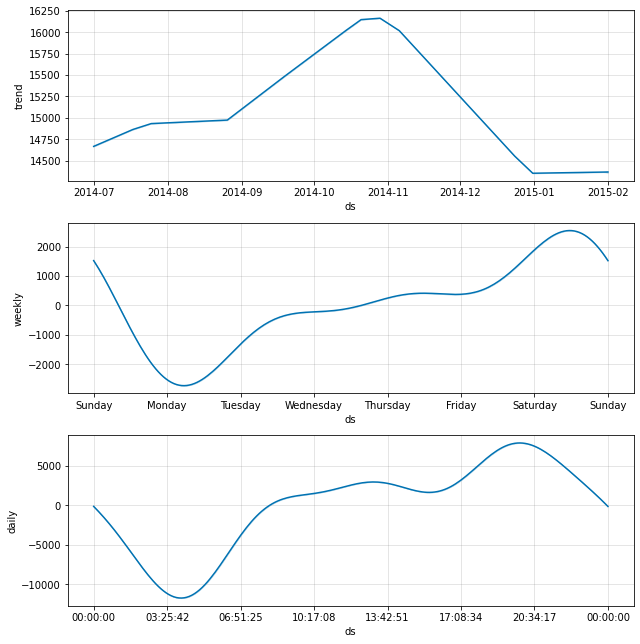

In [34]:
comp=m.plot_components(forecast)